In [1]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings to keep the output clean

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from scipy.stats import skew, kurtosis
from scipy.fft import fft
import scipy.signal as signal

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import IsolationForest

import xgboost as xgb
from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import label_binarize


In [2]:
# Load a Parquet file into a DataFrame
file_path = 'D:/classification_problem_dataset.parquet'
dff = pd.read_parquet(file_path)

dff.head()

,id,signal,label
0,0,"[-998, 776, -157, 2359, 2026, -1222, -1081, -1...",0
1,1,"[975, 1043, -1150, -1237, 1484, 1564, -885, 29...",0
2,2,"[3129, 1087, -396, -1774, -3007, 775, -2478, -...",0
3,3,"[-2813, 829, -1529, -1297, 4251, -2893, -1363,...",0
4,4,"[3774, 900, 105, 177, 483, 3554, 986, -1235, 2...",0


In [3]:
# Check for missing values in 'signal' and 'label' columns
missing_values = dff.isnull().sum()
print("Missing values in each column:\n", missing_values)
print()

# Check for duplicates
# Convert signals to tuple for comparison purposes, if they are numpy arrays
dff['signal'] = dff['signal'].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) else x)
duplicate_rows = dff.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")
print()

# Check signal length consistency
signal_lengths = dff['signal'].apply(len)
print(f"Signal length range: {signal_lengths.min()} to {signal_lengths.max()}")

if signal_lengths.min() != signal_lengths.max():
    print("Warning: Signals have inconsistent lengths!")
    dff['signal'] = dff['signal'].apply(lambda x: x[:signal_lengths.min()])  # Trim signals to the smallest length
print()

# Check label distribution
label_counts = dff['label'].value_counts()
print(f"Label distribution:\n{label_counts}")

Missing values in each column:
 id        0
signal    0
label     0
dtype: int64

Number of duplicate rows: 0

Signal length range: 10000 to 10000

Label distribution:
1    243
2    123
0    119
Name: label, dtype: int64


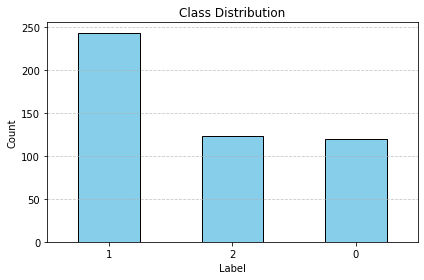

No significant imbalance detected.


In [4]:
# Visualize the distribution using a bar plot
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a subtle grid for better readability
plt.tight_layout()
plt.show()

# Check if the dataset is imbalanced
total_samples = len(dff)  # Total number of samples in the dataset
imbalance_threshold = 0.2  # Threshold for class imbalance (20%)
class_imbalance = label_counts / total_samples # Calculate the proportion of each class in the dataset

# Check if any class has an imbalance ratio greater than the threshold
imbalanced_classes = class_imbalance[class_imbalance < imbalance_threshold]
if not imbalanced_classes.empty:
    print(f"Imbalanced classes (less than {imbalance_threshold*100}% of total samples):\n{imbalanced_classes}")
else:
    print("No significant imbalance detected.")

In [5]:
# feature extraction function 
def extract_features(signal):
    signal = np.array(signal) # Convert the signal to a numpy array
   
    # Time-domain features
    mean = np.mean(signal)  # Mean of the signal
    variance = np.var(signal)  # Variance of the signal
    skewness = skew(signal)  # Skewness (asymmetry) of the signal distribution
    kurt = kurtosis(signal)  # Kurtosis (tailedness) of the signal distribution
    peak_to_peak = np.ptp(signal)  # Difference between the maximum and minimum value in the signal
    zero_crossing_rate = ((signal[:-1] * signal[1:]) < 0).sum()  # Zero-crossing rate: the number of times the signal crosses zero
    rms = np.sqrt(np.mean(np.square(signal)))  # Root Mean Square (RMS) value of the signal
    median = np.median(signal)  # Median of the signal
    range_value = np.max(signal) - np.min(signal)  # Range: max value - min value
    
    # Frequency-domain features using FFT (Fast Fourier Transform)
    fft_values = fft(signal)
    freq = np.abs(fft_values)[:len(signal)//2]  # Take the positive half of the FFT result
    spectral_entropy = -np.sum(freq * np.log(freq + 1e-9))  # Spectral entropy, with a small constant to avoid log(0)
    spectral_centroid = np.sum(freq * np.arange(1, len(freq) + 1)) / np.sum(freq)  # Spectral centroid
    spectral_bandwidth = np.sqrt(np.sum((np.arange(1, len(freq) + 1) - spectral_centroid) ** 2 * freq) / np.sum(freq))  # Spectral bandwidth
    spectral_flatness = np.exp(np.mean(np.log(freq + 1e-9))) / np.mean(freq)  # Spectral flatness
    
    # Return the features as a list
    return [mean, variance, skewness, kurt, peak_to_peak, zero_crossing_rate, rms, median, range_value,
            spectral_entropy, spectral_centroid, spectral_bandwidth, spectral_flatness]


# Apply feature extraction to all signals in the dataframe
features = [extract_features(signal) for signal in dff['signal']]

# Convert the list of features into a DataFrame
feature_columns = ['mean', 'variance', 'skewness', 'kurtosis', 'peak_to_peak', 'zero_crossing_rate', 'rms', 'median', 'range',
                   'spectral_entropy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness']

# Create a DataFrame from the extracted features and add the label column
df = pd.DataFrame(features, columns=feature_columns)
df['label'] = dff['label']

df.head()

,mean,variance,skewness,kurtosis,peak_to_peak,zero_crossing_rate,rms,median,range,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,label
0,16.0086,1.311108e+07,-0.034939,17.937659,62282,4541,3620.957962,-16.5,62282,-1.167300e+10,2073.276218,1571.962545,0.736843,0
1,-0.3208,1.323076e+07,-0.026105,19.815905,63606,4584,3637.411034,35.0,63606,-1.169810e+10,2054.735230,1570.613502,0.724599,0
2,-3.7474,1.233725e+07,-0.046958,20.064282,64502,4547,3512.443632,4.0,64502,-1.140862e+10,2062.158850,1565.140565,0.736024,0
3,0.4647,1.343164e+07,0.058908,19.822596,65135,4566,3664.920165,6.5,65135,-1.181875e+10,2072.855579,1572.167066,0.730226,0
4,-16.9441,1.253169e+07,0.057210,20.243258,65076,4643,3540.052587,-26.0,65076,-1.132173e+10,2067.254632,1571.721593,0.730832,0


Selected Features: ['variance', 'kurtosis', 'peak_to_peak', 'zero_crossing_rate', 'rms', 'range', 'spectral_entropy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness']


,Feature,Chi-squared Score
11,spectral_bandwidth,455.811752
10,spectral_centroid,289.619760
12,spectral_flatness,134.842007
5,zero_crossing_rate,130.317616
3,kurtosis,76.021262
1,variance,59.835747
6,rms,57.281493
9,spectral_entropy,43.730627
4,peak_to_peak,2.747192
8,range,2.747192


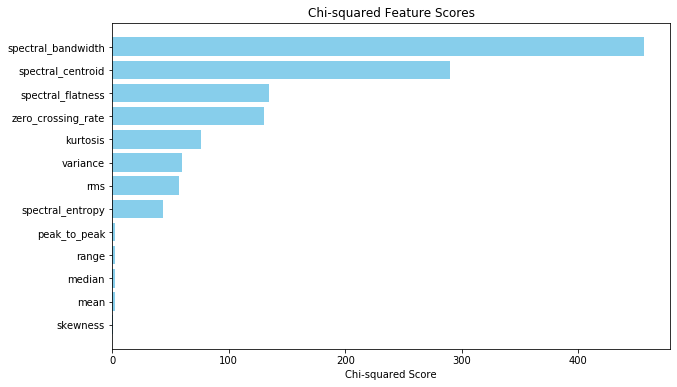

In [6]:
# Feature selection using Chi-squared test
def select_features_chi2(df, k=10, n_bins=5, strategy='uniform'):
    # Separate features and labels
    X = df.drop(columns=['label'])
    y = df['label']

    # Discretize features
    kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    X_discretized = kbins.fit_transform(X)
    
    # Apply Chi-squared feature selection
    chi2_selector = SelectKBest(score_func=chi2, k=k)
    X_selected = chi2_selector.fit_transform(X_discretized, y)
    
    # Get selected features
    selected_indices = chi2_selector.get_support(indices=True)
    selected_features = [X.columns[i] for i in selected_indices]
    
    # Create a DataFrame to show feature names and their Chi-squared scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Chi-squared Score': chi2_selector.scores_
    }).sort_values(by='Chi-squared Score', ascending=False)
    
    return X_selected, selected_features, feature_scores

# Perform feature selection
X_selected, selected_features, feature_scores = select_features_chi2(df, k=10)
print("Selected Features:", selected_features)
display(feature_scores)

# Plot Chi-squared scores
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Chi-squared Score'], color='skyblue')
plt.xlabel('Chi-squared Score')
plt.title('Chi-squared Feature Scores')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
plt.show()

In [7]:
# Select only the features chosen by the Chi-squared test
df = df[selected_features]
df['label'] = dff['label']

df.head()

,variance,kurtosis,peak_to_peak,zero_crossing_rate,rms,range,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,label
0,1.311108e+07,17.937659,62282,4541,3620.957962,62282,-1.167300e+10,2073.276218,1571.962545,0.736843,0
1,1.323076e+07,19.815905,63606,4584,3637.411034,63606,-1.169810e+10,2054.735230,1570.613502,0.724599,0
2,1.233725e+07,20.064282,64502,4547,3512.443632,64502,-1.140862e+10,2062.158850,1565.140565,0.736024,0
3,1.343164e+07,19.822596,65135,4566,3664.920165,65135,-1.181875e+10,2072.855579,1572.167066,0.730226,0
4,1.253169e+07,20.243258,65076,4643,3540.052587,65076,-1.132173e+10,2067.254632,1571.721593,0.730832,0


In [8]:
# Features to be removed
# Identify the features with a Chi-squared score below the threshold
threshold = 5
features_to_remove = set(feature_scores[feature_scores['Chi-squared Score'] < threshold].Feature)
# Find the intersection of these features with the columns of df to ensure that only those features are removed
features_to_remove_new = set(df.columns).intersection(features_to_remove)

# Remove the specified features from the feature set
df = df.drop(columns=features_to_remove_new)

df.head()

,variance,kurtosis,zero_crossing_rate,rms,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,label
0,1.311108e+07,17.937659,4541,3620.957962,-1.167300e+10,2073.276218,1571.962545,0.736843,0
1,1.323076e+07,19.815905,4584,3637.411034,-1.169810e+10,2054.735230,1570.613502,0.724599,0
2,1.233725e+07,20.064282,4547,3512.443632,-1.140862e+10,2062.158850,1565.140565,0.736024,0
3,1.343164e+07,19.822596,4566,3664.920165,-1.181875e+10,2072.855579,1572.167066,0.730226,0
4,1.253169e+07,20.243258,4643,3540.052587,-1.132173e+10,2067.254632,1571.721593,0.730832,0


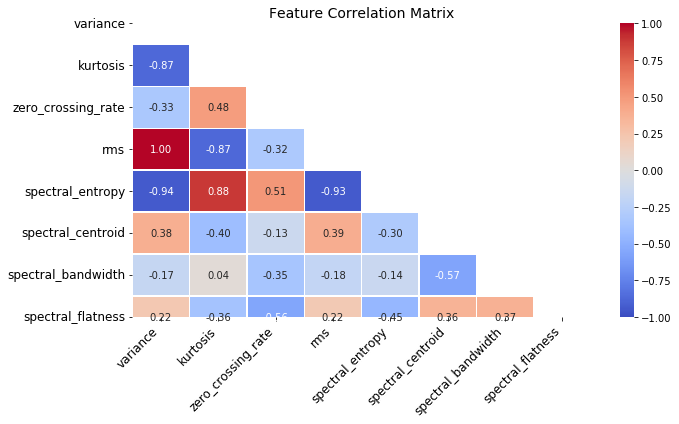

Highly Correlated Features (correlation > 0.9):
('variance', 'rms')
('variance', 'spectral_entropy')
('rms', 'spectral_entropy')


In [9]:
# Plotting the correlation matrix with a mask for the upper triangle
plt.figure(figsize=(10, 6))

# Compute the correlation matrix for features
corr_matrix = df.drop(columns = 'label').corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with the mask
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True,
            annot_kws={'size': 10}, linewidths=0.5, vmin=-1, vmax=1, mask=mask)

plt.title("Feature Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal
plt.tight_layout() 
plt.show()

# Identify pairs of highly correlated features (correlation > 0.9)
high_corr_pairs = np.where(np.abs(corr_matrix) > 0.9)
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y]) 
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

# Display high correlation pairs
print("Highly Correlated Features (correlation > 0.9):")
for pair in high_corr_pairs:
    print(pair)

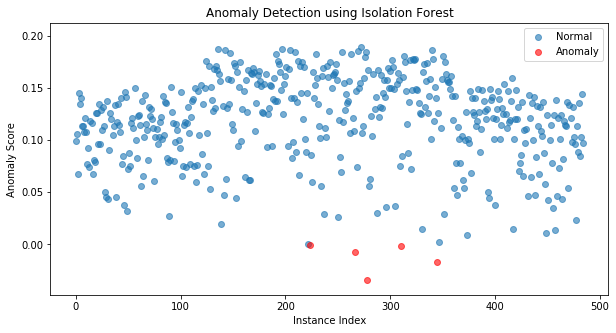

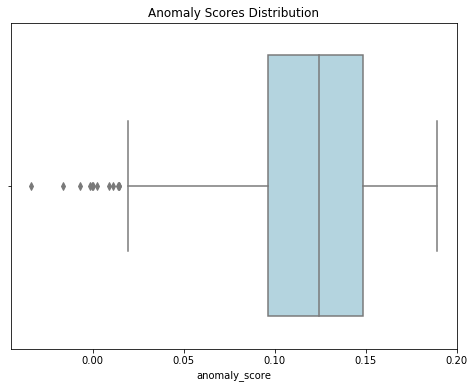

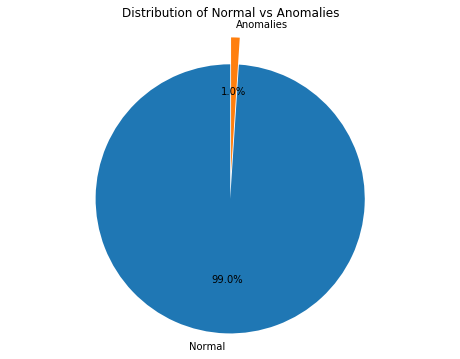

In [10]:
# Select numeric features for anomaly detection
features = df.select_dtypes(include=[np.number])

# Scale numeric features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Initialize Isolation Forest for anomaly detection
n_estimators = 100  # Number of trees in the forest
contamination = 0.01  # Expected proportion of outliers
sample_size = 256  # Number of samples to train each tree

iso_forest = IsolationForest(n_estimators=n_estimators,
                             contamination=contamination,
                             max_samples=sample_size,
                             random_state=123)

# Fit the Isolation Forest to the feature data
iso_forest.fit(features)

# Calculate anomaly scores and classify anomalies
df['anomaly_score'] = iso_forest.decision_function(features)  # Calculate anomaly score
df['anomaly'] = iso_forest.predict(features)  # Predict anomalies (1 for normal, -1 for anomaly)

# Visualize normal vs anomaly using scatter plot
plt.figure(figsize=(10, 5))

normal = df[df['anomaly'] == 1]  # Instances classified as normal
plt.scatter(normal.index, normal['anomaly_score'], label='Normal', alpha=0.6)

anomalies = df[df['anomaly'] == -1]  # Instances classified as anomalies
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly', color='red', alpha=0.6)

plt.xlabel("Instance Index")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Detection using Isolation Forest")
plt.legend()
plt.show()

# Box plot to better visualize the distribution of anomaly scores
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['anomaly_score'], color='lightblue')
plt.title('Anomaly Scores Distribution')
plt.show()

# Pie chart for the distribution of normal vs anomalies
labels = ['Normal', 'Anomalies']
sizes = [df[df['anomaly'] == 1].shape[0], df[df['anomaly'] == -1].shape[0]]  # Count normal vs anomalies

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.2, 0))
plt.title('Distribution of Normal vs Anomalies')
plt.axis('equal')
plt.show()

In [11]:
# Extract anomalies from the dataframe 
anomalies = df[df['anomaly'] == -1]
# Display the count of each label among the anomalies
display(dict(Counter(anomalies['label'])))

print("Unique labels in df['label']:", df['label'].unique())

{1: 5}

Unique labels in df['label']: [0 1 2]


In [12]:
df.head()

,variance,kurtosis,zero_crossing_rate,rms,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,label,anomaly_score,anomaly
0,1.311108e+07,17.937659,4541,3620.957962,-1.167300e+10,2073.276218,1571.962545,0.736843,0,0.098916,1
1,1.323076e+07,19.815905,4584,3637.411034,-1.169810e+10,2054.735230,1570.613502,0.724599,0,0.105437,1
2,1.233725e+07,20.064282,4547,3512.443632,-1.140862e+10,2062.158850,1565.140565,0.736024,0,0.067756,1
3,1.343164e+07,19.822596,4566,3664.920165,-1.181875e+10,2072.855579,1572.167066,0.730226,0,0.144622,1
4,1.253169e+07,20.243258,4643,3540.052587,-1.132173e+10,2067.254632,1571.721593,0.730832,0,0.134755,1


In [13]:
# Split the data into training and test sets 
X = df.drop(columns=['label','anomaly_score','anomaly'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Initialize the XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',   # Multi-class classification
    num_class=len(np.unique(y)),  # Number of classes
    max_depth=6,                  # Depth of the trees
    learning_rate=0.1,            # Learning rate (eta)
    eval_metric='mlogloss',       # Multi-class log loss
    random_state=123,
    n_estimators=100,             # Number of boosting rounds
    early_stopping_rounds=10      # Early stopping to avoid overfitting
)

# Train the model without verbose output
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Predict on the test data
y_pred = model.predict(X_test)

Confusion Matrix:
[[27  0  0]
 [ 0 45  0]
 [ 0  0 25]]


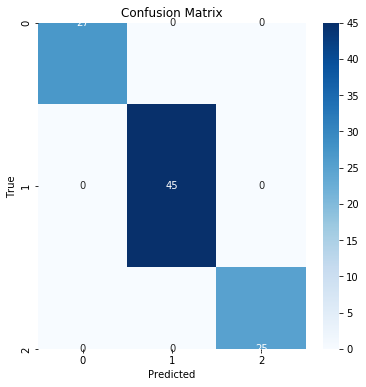

In [14]:
# confusion matrix  
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
# F1 Score

f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted F1 score for multi-class classification
print(f"Weighted F1 Score: {f1:.4f}")

Weighted F1 Score: 1.0000


Class 0 - AUC: 1.00
Class 1 - AUC: 1.00
Class 2 - AUC: 1.00


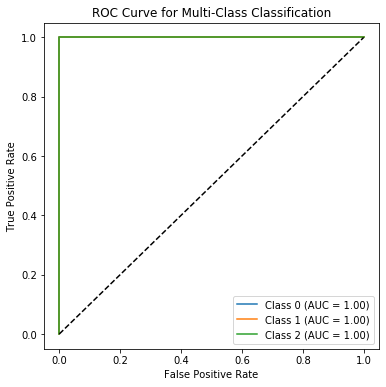

In [16]:
# ROC Curve and AUC

# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)  # Predict probabilities instead of labels

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Compute ROC curve and AUC for each class
n_classes = len(np.unique(y))  # Get the number of unique classes
fpr = dict()  # Dictionary to store false positive rates for each class
tpr = dict()  # Dictionary to store true positive rates for each class
roc_auc = dict()  # Dictionary to store AUC for each class

# Loop through each class to compute the ROC curve and AUC
for i in range(n_classes):
    # Compute the ROC curve for each class (FPR and TPR)
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    # Calculate the AUC for each class
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    print(f"Class {i} - AUC: {roc_auc[i]:.2f}")  # Print AUC for each classs
    
# Plot the ROC curve for all classes
plt.figure(figsize=(6, 6))
# Loop through each class and plot the ROC curve for that class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Filter out anomalies (instances with anomaly flag -1)
anomalies = df[df['anomaly'] == -1]  # Instances classified as anomalies

# Use model.predict() to get class labels for the test data
y_pred_anomalies = model.predict(X_test)  

# Ensure that y_test is properly formatted (and check its values)
y_true_anomalies = y_test.to_numpy()  # Convert to numpy array (if it's not already)

# Check for the shape and type of predictions and true labels
print("Predictions for anomalies:", y_pred_anomalies[:10])  
print("True labels for anomalies:", y_true_anomalies[:10])  
print()

# Compute precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_anomalies, y_pred_anomalies, average='macro')
recall = recall_score(y_true_anomalies, y_pred_anomalies, average='macro')
f1 = f1_score(y_true_anomalies, y_pred_anomalies, average='macro')

# Print evaluation metrics
print(f"Precision (Macro-average) for anomalies: {precision:.4f}")
print(f"Recall (Macro-average) for anomalies: {recall:.4f}")
print(f"F1 Score (Macro-average) for anomalies: {f1:.4f}")

Predictions for anomalies: [2 2 0 2 2 0 1 1 0 0]
True labels for anomalies: [2 2 0 2 2 0 1 1 0 0]

Precision (Macro-average) for anomalies: 1.0000
Recall (Macro-average) for anomalies: 1.0000
F1 Score (Macro-average) for anomalies: 1.0000


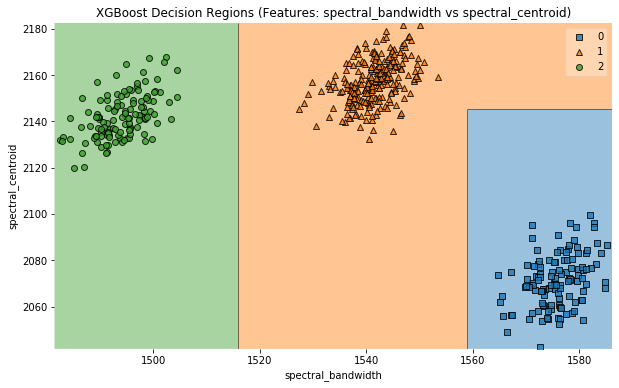

In [18]:
# decision region visualization

# Select the two most important features for visualization
top_feature_names = ['spectral_bandwidth', 'spectral_centroid']
X_combined = X[top_feature_names].values  # Extract the two selected features from the dataframe
y_combined = y.values  # Convert y to a NumPy array

# Train a new model using only the two selected features for visualization
model_viz = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, objective='multi:softprob')
model_viz.fit(X_combined, y_combined)  # Train on the two most important features

# Plot decision regions for the two selected features
fig, ax = plt.subplots(figsize=(10, 6))

plot_decision_regions(X_combined, y_combined, clf=model_viz, legend=1, ax=ax)

ax.set_xlabel(top_feature_names[0])
ax.set_ylabel(top_feature_names[1])
ax.set_title(f'XGBoost Decision Regions (Features: {top_feature_names[0]} vs {top_feature_names[1]})')
plt.show()